In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as no
from numpy.fft import rfft, irfft

In [2]:
def sinc(x):
    r=sin(x*2*np.pi)/(x*2*np.pi)
    r[np.isnan(r)]=1.0
    return r

2048


/home/anze/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/home/anze/local/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


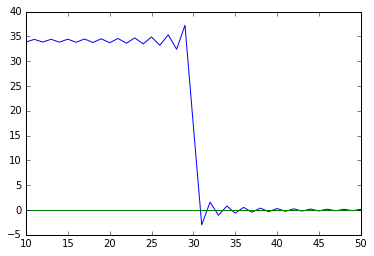

In [3]:
N=2048
x=np.hstack((np.arange(N/2),arange(-N/2,0)))
a=sinc(x*30./N)
plt.plot(rfft(a))
plt.plot(np.imag(rfft(a)))
plt.xlim(10,50)
print(len(x))

In [4]:
def generate_signal(N=2**27,ipeak=0.5):
    Nfft=N/2+1
    a=np.random.normal(0,1e-4,Nfft)+1j*np.random.normal(0,1e-4,Nfft)
    a[int(Nfft*ipeak+Nfft/128*0.341)]=1000*(1+0.3j) ## offset to get some ringing
    return irfft(a)
    


In [5]:
def getPS(data,avg):
    fdata=rfft(data)
    ps=abs(fdata[1:]**2)
    ps=ps.reshape((-1,avg))
    return ps.mean(axis=1)/len(data)

In [6]:
def getAvgPS(data,Nfft,Np):
    ## 2^20 FFT, 128, times
    N0=len(data)
    Na=Nfft/2/Np
    print Na
    l=[]
    for i in range(N0/Nfft):
        l.append(getPS(data[Nfft*i:Nfft*(i+1)],Na))
    l=np.array(l)
    return l.mean(axis=0)


In [7]:
N0=2**27
Np=128
sig=generate_signal(N0)

16384
4096
4
2
1


[]

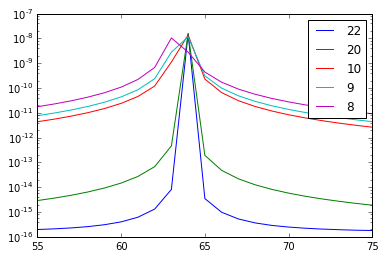

In [9]:
t22=getAvgPS(sig,2**22,Np)
plt.plot(t22,label='22')
plt.plot(getAvgPS(sig,2**20,Np),label='20')
plt.plot(getAvgPS(sig,1024,Np),label='10')
plt.plot(getAvgPS(sig,512,Np),label='9')
t8=getAvgPS(sig,256,Np)
plt.plot(t8,label='8')
plt.xlim(55,75)
plt.legend()
plt.semilogy()


In [10]:
def polyphase(data,Np,Ntaps):
    N0=len(data)
    Nfft=Np*2
    Nchunk=Nfft*Ntaps
    ## way 1
    if True:
        x=np.arange(-Nchunk/2+1,Nchunk/2+1)
        ## not sure what should go in here
        sinctemp=sinc(1.0*x*(Ntaps/2.)/Nchunk)/Nfft
    else:
        t=np.zeros(Nchunk/2+1,np.complex)
        t[:Ntaps/2-1]=1.0
        sinctemp=irfft(t)
        sinctemp=np.hstack((sinctemp[Nchunk/2:],sinctemp[:Nchunk/2]))
        #plt.plot(sinctemp)
        #stop()
    l=[]
    for i in xrange(N0/Nfft-Ntaps): ## just skip last ones for now
        cdata=np.array(data[i*Nfft:i*Nfft+Nchunk])
        cdata*=sinctemp
        #plt.plot(cdata)
        #stop()
        ## now fold over
        for j in xrange(1,Ntaps):
            cdata[0:Nfft]+=cdata[Nfft*j:Nfft*(j+1)]
        cdata=cdata[0:Nfft]
        l.append(abs((rfft(cdata)[1:])**2))
    l=np.array(l)
    return l.mean(axis=0)

In [11]:
phase6=polyphase(sig,Np,6)
phase5=polyphase(sig,Np,5)
phase4=polyphase(sig,Np,4)

/home/anze/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


[]

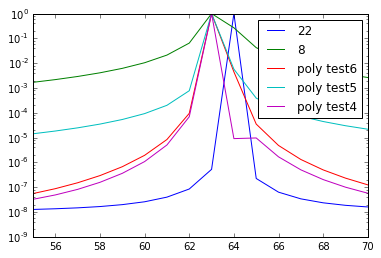

In [12]:

plt.plot(t22/t22.max(),label='22')
plt.plot(t8/t8.max(),label='8')
plt.plot(phase6/phase6.max(),label='poly test6')
plt.plot(phase5/phase5.max(),label='poly test5')
plt.plot(phase4/phase4.max(),label='poly test4')
plt.xlim(55,70)
plt.legend()
plt.semilogy()